In [1]:
from scipy import sparse
import numpy as np
import itertools
import copy

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import gaussian_kde
from tqdm import tqdm_notebook
from seaborn import kdeplot

In [2]:
interaction_matrix = sparse.load_npz('../data/interaction_matrix_pchembl.npz')
#interaction_matrix = np.array(interaction_matrix.todense())

interaction_dates = sparse.load_npz('../data/interaction_dates_pchembl.npz')
#interaction_dates = np.array(interaction_dates.todense())

In [3]:
import sys
sys.path.append("..")
import utils
#testing number of rows in utils.train_test_split:
#train, test = utils.train_test_split(interaction_matrix.toarray(), 0.05)

The publication dates of the interactions are recorded in ChEMBL. Looking below we can see the distribution of years: 

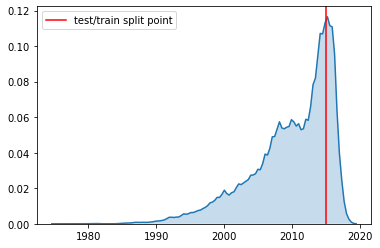

In [4]:
#removing 'year=1' which were originally NaNs in ChEMBL:
_ = kdeplot(interaction_dates.data[interaction_dates.data>1950], shade=True)
#bonus - set 'cumulative=True' in kdeplot to visualize the amount of data that will be in the test set.
plt.axvline(2015, c='red', label='test/train split point')
plt.legend()

These can thus be used to perform time-split cross validation, which simulates prospective validation. The below sets a year, and creates a training matrix with all interactions equal to or before that year, and a test matrix with all interactions from after that year. 

In [5]:
year = 2010

#turn interaction dates into a masker
dates_mask = (interaction_dates.data<=year).astype(int)

#make copies that will become train / test matrices
train = copy.copy(interaction_matrix)
test = copy.copy(interaction_matrix)

#remove 2015 and later records from train matrix
train.data = train.data * dates_mask
#remove all training data from the test matrix. 
test.data = test.data - train.data

#remove any rows from the train matrix that have zero interactions.
#this is the case any time a new ligand is discovered in 2015 or after. 
#we can't use link prediction on new ligands! It's a cold start problem. 
#so we remove all these ligands from the present analysis. 
row_mask = np.array((train.sum(axis=1)!=0)).reshape(1,-1)[0] #there must be a cleaner way to do that.
train = train[row_mask] 
test = test[row_mask]

train.eliminate_zeros()
test.eliminate_zeros()

In [6]:
print(train.sum(), test.sum(), (test.sum()/train.sum())*100)
test.sum()
      

233955.0 2494.0 1.0660169690752497


2494.0

# Predict label scores using label correlation

In [7]:
##This version uses sparse matrices, which keeps everything low
##memory. But it's a bit slower because getting/setting sparse objects is in general
##slower than numpy. 
def makeCorrelations(y_in):
    assert isinstance(y_in, sparse.csr_matrix)
    tot_instances = np.array(y_in.sum(axis=0))[0]
    L = sparse.lil_matrix((y_in.shape[1], y_in.shape[1]))

    for idx in tqdm_notebook(range(y_in.shape[0]), smoothing=0.1):
        row = y_in[idx]
        if row.sum()>1:
            for j,k in itertools.permutations(row.nonzero()[1], 2):
                L[j,k] += (1)/(tot_instances[k])             
    return L

##This calculates predicted probabilities for labels (1's in the train matrix are preserved as 1's)
def makePredictions(y_in, L):
    L1 = 1-L.toarray() #working with dense array is much easier for this. 
                    #but because it's only numLabels x numLabels it's not that big.
    y_new = y_in.toarray().astype('float32') #working with a dense array again
                                             #for ease of row-wise, elementwise addition 
    for count, row in tqdm_notebook(enumerate(y_in), total=y_in.shape[0], smoothing=0.1):
        posLines = row.nonzero()[1]
        corrs = L1[:,posLines]
        probs = 1-np.prod(corrs, axis=1)
        y_new[count]+=probs #elementwise addition here. 
        y_new[count] = np.clip(y_new[count], 0, 1)
    return sparse.csr_matrix(y_new)

In [8]:
L = makeCorrelations(train)
lc_preds = makePredictions(train, L)

In [12]:
def bapbap(predictions, test):
    #if isinstance(test, sparse.csr_matrix):
    #    test = test.toarray()

    #This will mask all ROWS that contain no test ligands. No point ranking
    #a row if you're aren't going to evaluate the ranks!
    #(and it works on sparse or np.array)
    row_mask = np.array(test.sum(axis=1)>0).reshape(-1,)
    test_masked = test[row_mask]
    get_ranks = test_masked.astype(bool)
    prediction_ranks = rankdata(-predictions[row_mask], axis=1)

In [21]:
predictions = copy.copy(lc_preds)
if isinstance(predictions, sparse.csr_matrix):
	predictions = predictions.toarray()
from scipy.stats.mstats import rankdata
row_mask = np.array(test.sum(axis=1)>0).reshape(-1,)
test_masked = test[row_mask]
get_ranks = test_masked.astype(bool)
prediction_ranks = rankdata(-predictions[row_mask], axis=1)

# Predict label scores using implicit BPR:

In [9]:
import implicit
model = implicit.bpr.BayesianPersonalizedRanking(factors=337,
                                                learning_rate=0.06276,
                                                regularization=0.001147,
                                                iterations=25,
                                                use_gpu=False)
model.fit(train)

imbpr_preds = np.dot(model.item_factors, model.user_factors.T)

In [23]:
def return_mean_rank(preds, test):
    t = test.toarray().astype(bool)
    #order from highest to lowest:
    order = (-preds).argsort(axis=1)
    #get ranks of each ligand.
    ranks = order.argsort(axis=1)
    return ranks[t]

In [32]:
lc_ranks = return_mean_rank(lc_preds.toarray(), test)

In [33]:
imbpr_ranks = return_mean_rank(imbpr_preds, test)

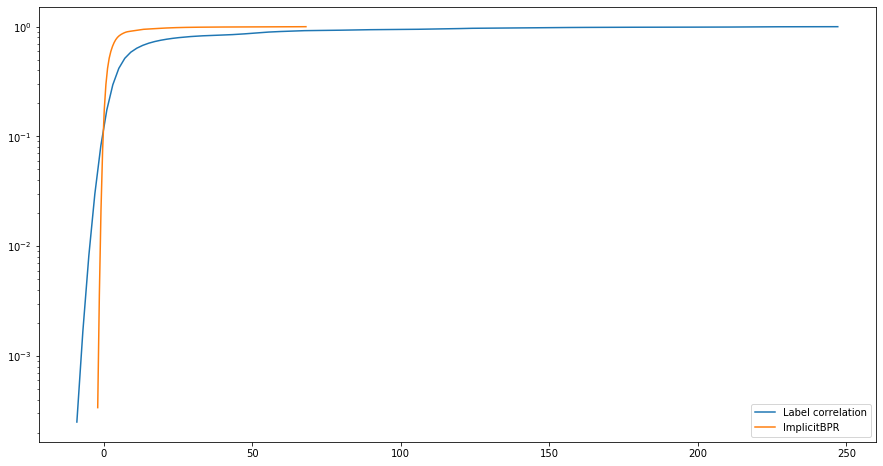

In [38]:
plt.figure(figsize=(15,8))
kdeplot(lc_ranks, label='Label correlation', cumulative=True)
kdeplot(imbpr_ranks, label='ImplicitBPR', cumulative=True)
plt.yscale('log')

In [41]:
from statsmodels.distributions import ECDF
ecdf = ECDF(lc_ranks)

In [62]:
lc_ranks

array([  7,  12,  24, 116,  62, 134,   8,  17,  16,   2,   3,  13,  27,
         8,   2,   6,  12,   5,  13,   8, 102,   1, 111, 133,  10,  45,
        45,  10,  45,  45, 136,   6,  10,   1,   2,   4,   3, 111,  10,
         2,   1,   3,   2,   3,   2,   3,   5,   3,  32,   2,   1, 101,
        10,  61,   4,  37,  40,   9,   6,  13,  45,   7,  18, 118,   7,
         6,   4,   2,   1,  13,  14,   2,   5,  50,   3,   2,   1,   2,
         1,  10,   1,   1,  64,  64,  10,  64,   1, 211,  56,   1,   9,
        11,   3,   9, 106,   3,  14,   2,   4,   7,  31,   3,   7,   5,
         9,   8,  17,  27,  30,  21,  54,  23,  18,  87,  10,   7,  88,
         3,   8,  11,  17,  15,  21,  31,  10,   3,   7,   6,  37,   8,
        20,   2,  22,  13,  29,  25,   4,  16,   9,  19,  23,  51,   5,
        14,  24,  50, 121,   3,   3,   3,  53,  53,  53,  53,  53,  53,
        53,  10,   8,   2,   4,   4,   3,   3,   4,  22,   6,  51,   1,
        10,   5,  10,   5,  11,  10,   5,   5,   3,   3,   8,   

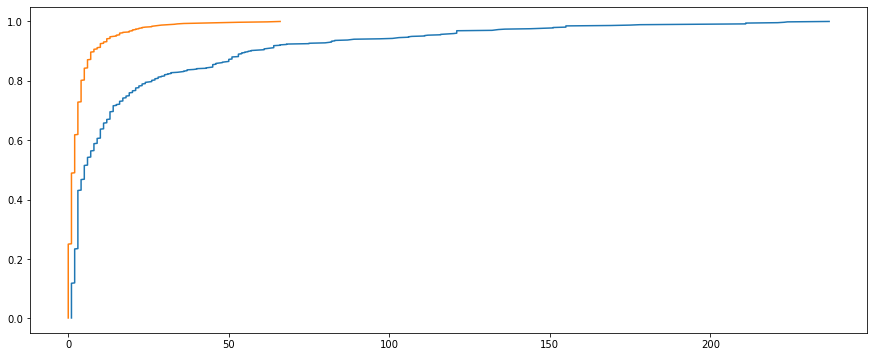

In [51]:
plt.figure(figsize=(15,6))
ecdf = ECDF(lc_ranks)
plt.plot(ecdf.x, ecdf.y, label='Label correlation')
ecdf = ECDF(imbpr_ranks)
plt.plot(ecdf.x, ecdf.y, label='ImplicitBPR')

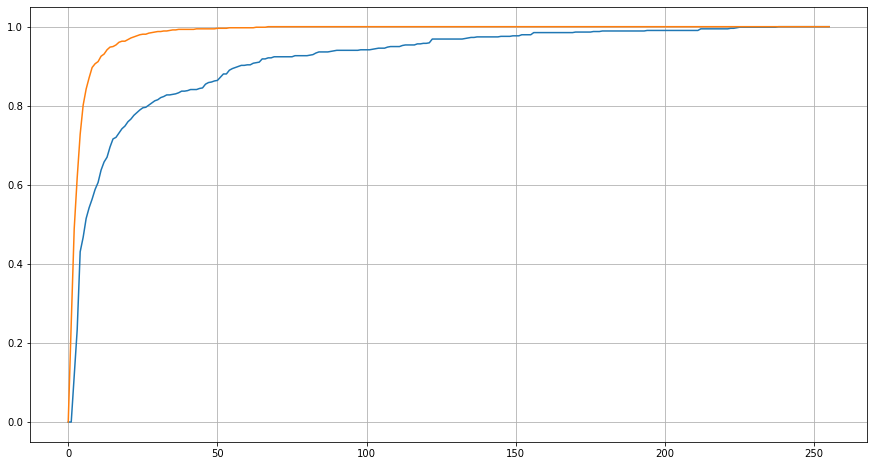

In [66]:
plt.figure(figsize=(15,8))
#bal = [(test_ranks<i).sum()/len(test_ranks) for i in range(0, 20)]
plt.plot([(lc_ranks<i).sum()/len(lc_ranks) for i in range(0, 256)])
plt.plot([(imbpr_ranks<i).sum()/len(imbpr_ranks) for i in range(0, 256)])
plt.grid()

In [69]:
sum([(imbpr_ranks<i).sum()/len(imbpr_ranks) for i in range(0, 256)])

251.4415760869565

In [70]:
sum([(lc_ranks<i).sum()/len(imbpr_ranks) for i in range(0, 256)])

234.30163043478237

In [35]:
print(np.median(pa))
print(np.median(wa))

5.0
2.0


In [ ]:
#order from highest to lowest:
order2 = (-pred_matrix2).argsort(axis=1)
#get ranks of each ligand.
ranks2 = order2.argsort(axis=1)

In [ ]:
#order from highest to lowest:
order2 = (-pred_matrix2).argsort(axis=1)
#get ranks of each ligand.
ranks2 = order2.argsort(axis=1)

In [ ]:
order

In [ ]:
order2.T

In [ ]:
kdeplot(ranks2[test.T])

In [ ]:
from lightfm import LightFM, datasets
data = datasets.fetch_movielens()


In [ ]:
data['train']

In [ ]:
ranks2[test.T]

In [ ]:
kdeplot(ranks[test])

In [ ]:
##new version, reporting the average rank of test ligands.
#order from highest to lowest:
order = (-prediction_matrix).argsort()
#get ranks of each ligand. 
ranks = order.argsort()
    
#calc rank fo each ligand
#test2 = np.array(test.todense())
test_ranks = ranks[row_mask][np.array(test[row_mask], dtype=bool)]

plt.plot(test_ranks, linewidth=0.1)

In [ ]:
ranks = [(test_ranks<i).sum()/len(test_ranks) for i in range(0, 20)]
plt.plot(ranks)
plt.grid()

In [15]:
test.toarray().astype(bool)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

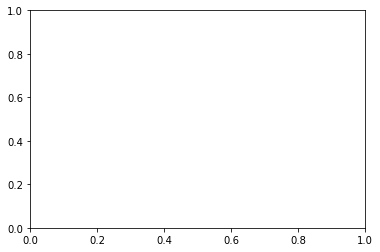

In [12]:
fig, ax = plt.subplots()

In [ ]:
import lightfm
##LightFM:                                                                                                                                                                     
#lightfm 'user id' (chemical id)                                                                                                                                               
cid = np.arange(train.shape[0])
#lightfm 'item id' (target id)                                                                                                                                                 
tid = np.arange(train.shape[1])
model = lightfm.LightFM(no_components = 127,
                           loss='warp',
                           max_sampled=9,
                           learning_rate=0.056129688436596194)
model.fit(sparse.csr_matrix(train), epochs=6)
lfm_prediction_matrix = model.predict(np.repeat(cid, len(tid)), np.tile(tid, len(cid)))
lfm_prediction_matrix = np.reshape(lfm_prediction_matrix, (len(cid), len(tid)))


In [ ]:
order_lc = (-lc_prediction_matrix).argsort()
#get ranks of each ligand. 
ranks_lc = order_lc.argsort()

order_im = (-im_prediction_matrix).argsort()
#get ranks of each ligand. 
ranks_im = order_im.argsort()

order_lfm = (-lfm_prediction_matrix).argsort()
#get ranks of each ligand. 
ranks_lfm = order_lfm.argsort()

In [ ]:
inverse_ranks_lc = 1/(order_lc.argsort()+1)
inverse_ranks_im = 1/(order_im.argsort()+1)
inverse_ranks_lfm = 1/(order_lfm.argsort()+1)

In [ ]:
inverse_combined = inverse_ranks_lc+inverse_ranks_im+inverse_ranks_lfm

In [ ]:
order_com = (-inverse_combined).argsort()
#get ranks of each ligand. 
ranks_com = order_com.argsort()
print(np.mean(ranks_com[np.array(test, dtype=bool)]))

In [ ]:
avg_ranks = (ranks_lc+ranks_im)/2

In [ ]:
print(np.mean(ranks_lc[np.array(test, dtype=bool)]))

print(np.mean(ranks_im[np.array(test, dtype=bool)]))

print(np.mean(avg_ranks[np.array(test, dtype=bool)]))

In [ ]:
##new version, reporting the average rank of test ligands.
#order from highest to lowest:
order = (-prediction_matrix).argsort()
#get ranks of each ligand. 
ranks = order.argsort()
    
#calc rank fo each ligand
#test2 = np.array(test.todense())
test_ranks = ranks[row_mask][np.array(test[row_mask], dtype=bool)]

plt.plot(test_ranks, linewidth=0.1)

In [ ]:
print(np.mean(test_ranks))
print(np.median(test_ranks))

plt.figure(figsize=(10,3))
density = gaussian_kde(test_ranks)
xs = np.linspace(0,243, 300)
density.covariance_factor = lambda : 0.25
density._compute_covariance()
plt.plot(xs,density(xs))
plt.axhline(0, c='k')
#plt.xlim(-0.5,150)
plt.scatter(test_ranks, np.zeros(len(test_ranks))+np.random.uniform(-0.02,0.0, len(test_ranks)), alpha=0.05)

In [ ]:
ranks = [(test_ranks<i).sum()/len(test_ranks) for i in range(0, 20)]
plt.plot(ranks)
plt.grid()

In [61]:
ranks

NameError: name 'ranks' is not defined

In [55]:
###load data:
#train, test = utils.load_time_split()

filenames = ['hpo_implicit_als.dat', 'hpo_implicit_bpr.dat',
             'hpo_lightfm_warp.dat', 'hpo_lightfm_bpr.dat']
def find_opt_pars(filename):
    f = open('../hyperparmeter_optimization/'+filename, 'r')
    record=False
    for line in f:
        if 'Paramaters:' in line:
            return [float(i) for i in line.strip('\n').replace('[', '').replace(']', '').replace(',', '').split()[1:]]




def train_implicit_als(pars):
    model = implicit.als.AlternatingLeastSquares(factors=int(pars[0]),
                                                     regularization=pars[1],
                                                     iterations=int(pars[2]),
                                                     num_threads=1,
                                                     use_gpu=False)
    model.fit(sparse.csr_matrix(train))
    prediction_matrix=np.dot(model.item_factors, model.user_factors.T)
    test_ranks = utils.evaluate_predictions(prediction_matrix, sparse.csr_matrix(test),avg=False)
    return np.mean(test_ranks), np.median(test_ranks)

def train_implicit_bpr(pars):
    model = implicit.bpr.BayesianPersonalizedRanking(factors=int(pars[0]),
                                                 learning_rate=pars[1],
                                                 regularization=pars[2],
                                                 iterations=int(pars[3]),
                                                 use_gpu=False)

    model.fit(sparse.csr_matrix(train))
    prediction_matrix=np.dot(model.item_factors, model.user_factors.T)
    #test_ranks = utils.evaluate_predictions(prediction_matrix, sparse.csr_matrix(test),avg=False)
    return np.mean(test_ranks), np.median(test_ranks)



##LightFM:
#lightfm 'user id' (chemical id)
cid = np.arange(train.shape[0])
#lightfm 'item id' (target id)
tid = np.arange(train.shape[1])



def train_lightfm_warp(pars):
    model = lightfm.LightFM(no_components = int(pars[0]),
                           loss='warp',
                           max_sampled=int(pars[1]),
                           learning_rate=pars[2])
    model.fit(sparse.csr_matrix(train), epochs=int(pars[3]))
    prediction_matrix = model.predict(np.repeat(cid, len(tid)), np.tile(tid, len(cid)))
    prediction_matrix = np.reshape(prediction_matrix, (len(cid), len(tid)))
    test_ranks = utils.evaluate_predictions(prediction_matrix, sparse.csr_matrix(test),avg=False)
    return np.mean(test_ranks), np.median(test_ranks)

def train_lightfm_bpr(pars):
    model = lightfm.LightFM(no_components = int(pars[0]),
                           loss='bpr',
                           max_sampled=int(pars[1]),
                           learning_rate=pars[2])
    model.fit(sparse.csr_matrix(train), epochs=int(pars[3]))
    prediction_matrix = model.predict(np.repeat(cid, len(tid)), np.tile(tid, len(cid)))
    prediction_matrix = np.reshape(prediction_matrix, (len(cid), len(tid)))
    test_ranks = utils.evaluate_predictions(prediction_matrix, sparse.csr_matrix(test),avg=False)
    return np.mean(test_ranks), np.median(test_ranks)




In [188]:
def train_implicit_bpr(pars):
    model = implicit.bpr.BayesianPersonalizedRanking(factors=int(pars[0]),
                                                 learning_rate=pars[1],
                                                 regularization=pars[2],
                                                 iterations=int(pars[3]),
                                                 use_gpu=False)

    model.fit(train)
    prediction_matrix=np.dot(model.item_factors, model.user_factors.T)
    #test_ranks = utils.evaluate_predictions(prediction_matrix, sparse.csr_matrix(test),avg=False)
    return prediction_matrix

def score_prediction_matrix(preds, test):
    t = test.toarray().astype(bool)
    #order from highest to lowest:
    order = (-preds).argsort(axis=1)
    #get ranks of each ligand.
    ranks = order.argsort(axis=1)
    return ranks[t]

#bpr:
pars = find_opt_pars(filenames[1])
preds = train_implicit_bpr(pars)
r = score_prediction_matrix(preds, test)

mean = np.mean(r)
print(mean)
median = np.median(r)
print(median)
#ecdf = [(r<i).sum()/len(r) for i in range(0, 243)]

for _ in range(16):
    preds += train_implicit_bpr(pars)
    r = score_prediction_matrix(preds, test)
    mean = np.mean(r)
    print(mean)
    median = np.median(r)
    print(median)


#    outfile.write(filenames[1]+': '+str(mean)+' '+str(median)+'\n')


44.00601443464314
19.0


42.87169206094627
19.0


40.92141138732959
18.0


39.900160384923815
17.0


39.21130713712911
17.0


39.162389735364876
17.0


39.30513231756215
17.0


38.90497193263833
17.0


38.985565356856455
17.0


39.088211708099436
17.0


39.07578187650361
17.0


38.95829991980754
17.0


38.71611868484362
17.0


38.6355252606255
17.0


38.56174819566961
17.0


38.66399358460305
17.0


38.54971932638332
17.0


In [192]:
preds
t = test.toarray().astype(bool)

In [217]:
#order from highest to lowest:
order = (-lc_preds.toarray()).argsort(axis=1)
#get ranks of each ligand.
ranks = order.argsort(axis=1)

In [309]:
for j,k in zip(*test.toarray().nonzero()):
    value = lc_preds[j,k]
    if value==0:
        one = (-lc_preds.toarray()[j]).argsort()
        two = one.argsort()
        print('Found a zero, is is rank:',two[k])
    print(j,k, value)

0 13 0.8103598
0 39 0.018454889
0 175 0.5758668
0 180 0.6142879
Found a zero, is is rank: 212
0 227 0.0
63 161 0.04511278
95 83 0.7572718
283 161 0.04511278
460 172 0.015224463
738 102 0.022362385
789 50 0.0028985508
911 89 0.94344497
911 191 0.34573984
911 196 0.6831216
932 19 0.010833222
983 105 0.6691352
1066 171 0.005254211
1120 65 0.06639874
1356 29 0.19130932
1388 172 0.0064892927
1482 172 0.0095877275
1609 9 0.7332495
1680 127 0.6892202
1680 165 0.12308869
1721 72 0.0006181425
1762 165 0.25429142
1762 177 0.5506438
Found a zero, is is rank: 221
1961 74 0.0
2219 88 0.83032054
2219 122 0.6137323
2274 212 0.023899179
2295 139 0.6121869
2295 141 0.4793976
2295 162 0.6003265
2333 228 0.0018544274
2466 105 0.008343265
2466 158 0.39035815
2846 88 0.560376
2846 116 0.6644975
2846 122 0.39696312
2896 188 0.54079694
2916 88 0.83032054
2916 122 0.6137323
3063 188 0.54079694
3165 88 0.83032054
3165 122 0.6137323
3330 119 0.5325
3615 90 0.969617
4083 27 0.08950617
4083 134 0.1090535
4108 60 

Found a zero, is is rank: 223
22409 106 0.0
22409 154 0.9805877
Found a zero, is is rank: 234
22409 160 0.0
22409 171 0.000683527
22409 196 0.8232349
22409 224 0.99915296
22573 71 0.30176818
22791 67 0.005415127
22791 70 0.009608786
22791 105 0.070011765
22851 53 0.24864385
22868 218 0.26233009
Found a zero, is is rank: 75
23172 165 0.0
Found a zero, is is rank: 67
23172 177 0.0
23220 235 0.001519295
23243 72 0.024916438
23259 56 0.023386437
Found a zero, is is rank: 217
23259 106 0.0
23494 113 0.9173548
23825 41 0.0010817493
23825 49 0.00247257
23825 56 0.0007726781
24310 34 0.8005997
24597 71 0.4278281
24738 34 0.8005997
Found a zero, is is rank: 236
24738 86 0.0
25003 108 0.82911074
25159 84 0.38681296
25217 27 0.0055632824
25217 37 0.0029361767
25217 134 0.006181425
25338 84 0.4566455
25599 71 0.018922018
25663 37 0.00743616
25898 84 0.38681296
25938 90 0.0043290043
26374 84 0.38681296
26410 37 0.6173322
26452 84 0.4566455
26483 73 0.9753057
26483 79 0.9930963
26483 136 0.8988582
2

Found a zero, is is rank: 98
47701 208 0.0
47717 156 0.0010548523
47804 139 0.4132066
47804 170 0.35667834
Found a zero, is is rank: 113
47944 208 0.0
47967 36 0.7822869
47967 48 0.39125356
47967 73 0.65128934
47967 79 0.8664841
47967 123 0.6608989
47967 138 0.8180746
47967 140 0.5634937
47967 183 0.62638885
47967 196 0.54703903
48186 79 0.9998014
48186 138 0.99999726
48219 150 0.4918004
48219 164 0.7528269
Found a zero, is is rank: 43
48268 138 0.0
Found a zero, is is rank: 164
48274 1 0.0
48274 36 0.4662162
48274 149 0.38175675
48330 152 0.12877178
48330 189 0.82020617
48550 155 0.9991551
48708 70 0.011656442
48820 11 0.9993879
48820 16 0.9997157
48820 31 0.9748112
48820 36 0.9997561
48820 79 0.9999223
48820 138 0.9999955
48820 224 0.99955654
48971 11 0.49081492
48971 13 0.48721373
48971 16 0.5124491
48971 29 0.42855603
48971 35 0.31474736
48971 73 0.45905605
48971 79 0.6024925
48971 89 0.5521836
48971 123 0.5000674
48971 125 0.1921583
48971 128 0.4850422
48971 133 0.4936518
48971 13

Found a zero, is is rank: 224
77952 72 0.0
78317 86 0.7563396
78317 116 0.008820287
Found a zero, is is rank: 105
78317 225 0.0
Found a zero, is is rank: 113
78317 233 0.0
78477 30 0.32984978
78715 91 0.8401437
78799 91 0.8401437
78808 78 0.5422147
79275 92 0.002621232
79276 181 0.052964948
79284 24 0.11793604
79284 25 0.09602188
79284 129 0.17274745
79284 155 0.8261327
79284 168 0.25748688
79284 202 0.8090222
79284 235 0.028110515
Found a zero, is is rank: 154
79432 228 0.0
79643 91 0.8401437
79729 91 0.8401437
79773 91 0.8401437
79805 91 0.8401437
79816 17 0.0011467889
79816 105 0.012041285
79953 29 0.009933775
79953 31 0.011589404
79953 36 0.011589404
79953 72 0.01986755
79953 73 0.014900662
79953 128 0.104304634
79953 154 0.01655629
79953 157 0.0066225166
79953 178 0.011589404
79953 180 0.009933775
79953 189 0.06291391
79953 214 0.008278145
79953 215 0.009933775
79953 218 0.0066225166
79953 237 0.011589404
79956 91 0.8401437
80002 144 0.008303091
80085 80 0.63284534
80225 84 0.6787

Found a zero, is is rank: 203
111535 107 0.0
111535 135 0.0016549494
111535 139 0.0011918951
111535 162 0.0016549494
111555 81 0.0026045663
111577 39 0.0038910506
111577 126 0.0029182879
111592 231 0.00015453562
112138 17 0.0029301092
112138 54 0.002312346
112138 108 0.0024667867
112174 13 0.2099344
112313 161 0.04511278
112324 14 0.3844925
112382 18 0.5200762
112382 68 0.7856044
112382 94 0.9632184
112382 112 0.71976197
112537 70 0.5871067
112731 161 0.04511278
Found a zero, is is rank: 30
112745 165 0.0
113011 90 0.0043290043
113176 39 0.012652889
113270 84 0.4566455
113540 84 0.24382187
114108 178 0.1302282
114466 0 0.786378
114466 13 0.910826
114466 73 0.94624734
114466 89 0.9497393
114466 149 0.9218285
114466 150 0.97954345
114466 164 0.9912494
114466 175 0.66846174
114466 183 0.90970606
114466 214 0.97287744
114468 119 0.5325
114796 52 0.002770083
114796 165 0.0016620499
114796 177 0.0016620499
115116 91 0.8401437
115122 7 0.04255319
115208 9 0.016364662
115208 99 0.0025146925
Fo

129450 113 0.91771805
129645 221 0.0009272137
129713 130 0.35699797
129729 105 0.07286346
129729 146 0.002857022
129729 228 0.011057988
129848 0 0.5691297
129848 11 0.9899049
129848 13 0.9622261
Found a zero, is is rank: 152
129848 28 0.0
129848 31 0.990496
129848 35 0.8154011
129848 73 0.9656723
129848 79 0.9812041
129848 89 0.8573348
129848 120 0.8761322
129848 128 0.8962539
129848 129 0.76828814
129848 133 0.8117961
129848 140 0.94144076
129848 142 0.3829718
129848 148 0.8826159
129848 149 0.9461115
129848 154 0.8560844
129848 168 0.026229294
129848 175 0.7488022
129848 176 0.76246834
129848 180 0.928277
129848 183 0.7130795
129848 189 0.69288
129848 193 0.6005309
129848 198 0.7628571
129848 204 0.95772517
129848 212 0.29833585
129848 214 0.9139958
129848 218 0.8809358
129848 222 0.7812826
129848 236 0.8326931
Found a zero, is is rank: 179
130078 9 0.0
130078 65 0.086294636
Found a zero, is is rank: 221
130078 71 0.0
Found a zero, is is rank: 230
130078 103 0.0
130078 120 0.06599535

Found a zero, is is rank: 144
145774 192 0.0
145971 120 0.06960082
146046 120 0.06960082
Found a zero, is is rank: 144
146166 192 0.0
Found a zero, is is rank: 144
146175 192 0.0
146497 76 0.7025029
146497 98 0.49936268
146526 150 0.15250544
146539 84 0.4566455
146815 105 0.04793028
146815 150 0.15250544
146815 205 0.6928105
147309 17 0.0015262404
147585 11 0.8406862
147585 16 0.83800745
Found a zero, is is rank: 202
147585 28 0.0
147585 31 0.64931697
147585 35 0.5412317
147585 36 0.8479864
147585 40 0.09406178
147585 48 0.6002006
147585 73 0.70894545
147585 79 0.86068374
147585 125 0.46431074
147585 131 0.87483466
147585 133 0.6546023
147585 136 0.5271503
147585 142 0.06812394
147585 148 0.51392037
147585 149 0.7207496
147585 150 0.6056436
147585 164 0.7909829
147585 175 0.3399573
147585 183 0.41757208
147585 212 0.03116683
147585 214 0.59760296
147585 224 0.8482135
147585 236 0.6084627
147914 99 0.0025146925
Found a zero, is is rank: 144
147914 192 0.0
147929 79 0.104781285
147929 13

In [330]:
a = np.array([[4,2,7,2,1],[1,2,3,4,5]])
rank = a.argsort(axis=1).argsort(axis=1)

unique, inverse = np.unique(a, return_inverse = True, axis=0)

unique_rank_sum = np.zeros_like(unique)
np.add.at(unique_rank_sum, inverse, rank)
unique_count = np.zeros_like(unique)
np.add.at(unique_count, inverse, 1)

unique_rank_mean = unique_rank_sum.astype(np.float) / unique_count

rank_mean = unique_rank_mean[inverse]

rank_mean

array([[3., 1., 4., 2., 0.],
       [0., 1., 2., 3., 4.]])

In [334]:
unique, inverse = np.unique(a, return_inverse = True, axis=1)
unique

array([[1, 2, 2, 4, 7],
       [5, 2, 4, 1, 3]])

In [337]:
unique_rank_sum = np.zeros_like(unique)
np.add.at(unique_rank_sum, inverse, rank)
unique_rank_sum

IndexError: index 3 is out of bounds for axis 0 with size 2

In [332]:
print(-lc_preds.toarray()[0][227])
one = (-lc_preds.toarray()[0]).argsort()
two = one.argsort()



-0.0


212

In [306]:
two[(-lc_preds.toarray()[0]==0)]

array([208, 215, 210, 227, 223, 219, 220, 230, 233, 234, 240, 207, 213,
       211, 205, 203, 214, 218, 235, 232, 226, 225, 239, 217, 221, 222,
       224, 228, 241, 231, 236, 238, 229, 204, 209, 212, 216, 202, 206,
       237, 242])

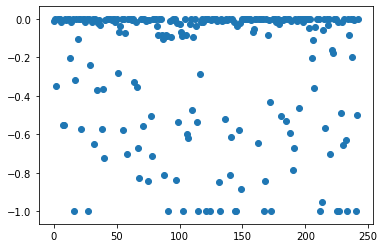

In [238]:
plt.scatter((-lc_preds.toarray()[0]).argsort(), (-lc_preds.toarray()[0]))

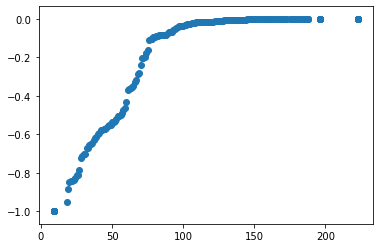

In [256]:
from scipy.stats import rankdata

plt.scatter(rankdata(-lc_preds.toarray()[0]), (-lc_preds.toarray()[0]))

In [367]:
from scipy.stats.mstats import rankdata
rankdata(-lc_preds.toarray()[:13000], axis=1)

array([[ 68. , 223. , 223. , ...,  89. , 223. , 223. ],
       [152.5, 152.5, 152.5, ..., 152.5, 152.5, 152.5],
       [163.5, 163.5, 163.5, ..., 163.5, 163.5, 163.5],
       ...,
       [129. , 129. , 129. , ..., 129. , 129. , 129. ],
       [129. , 129. , 129. , ..., 129. , 129. , 129. ],
       [126. , 126. , 126. , ..., 126. , 126. , 126. ]])

In [370]:
rm = np.array(test.sum(axis=1)>0).reshape(-1,)

In [372]:
test

<337951x243 sparse matrix of type '<class 'numpy.float64'>'
	with 11430 stored elements in Compressed Sparse Row format>

In [347]:
%%timeit
rm_ranked = rankdata(-lc_preds.toarray()[rm], axis=1)

569 ms ± 27.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [339]:
trm = test.toarray()[rm].astype(bool)

In [380]:
test.toarray()[rm]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [382]:
trm

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [381]:
rm_ranked

array([[ 68. , 223. , 223. , ...,  89. , 223. , 223. ],
       [135.5, 135.5, 135.5, ..., 135.5, 135.5, 135.5],
       [139.5, 139.5, 139.5, ..., 139.5, 139.5, 139.5],
       ...,
       [132. , 132. , 132. , ..., 132. , 132. , 132. ],
       [ 58. , 186.5, 186.5, ..., 123.5, 186.5, 186.5],
       [132. , 132. , 132. , ..., 132. , 132. , 132. ]])

In [386]:
def bapbap(predictions, test):
    
    row_mask = np.array(test.sum(axis=1)>0).reshape(-1,)
    test_masked = test[row_mask]
    get_ranks = test_masked.toarray().astype(bool) #this will select using boolean all test ranks.

    #rankdata approach, which correctly handles ties:
    prediction_ranks = rankdata(-predictions[row_mask], axis=1)

    #all ranks:
    prediction_ranks[get_ranks]
    return prediction_ranks

In [397]:
row_mask = np.array(test.sum(axis=1)>0).reshape(-1,)
row_mask

array([ True, False, False, ..., False, False, False])

In [398]:
test_masked = test[row_mask]
test_masked

<1164x243 sparse matrix of type '<class 'numpy.float64'>'
	with 2494 stored elements in Compressed Sparse Row format>

In [402]:
get_ranks = test_masked.toarray().astype(bool)
get_ranks

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [406]:
-lc_preds[row_mask].toarray()

array([[-0.2885058 , -0.        , -0.        , ..., -0.07072667,
        -0.        , -0.        ],
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       ...,
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.00668151, -0.        , -0.        , ..., -0.0003712 ,
        -0.        , -0.        ],
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ]], dtype=float32)

In [407]:
prediction_ranks = rankdata(-lc_preds[row_mask].toarray(), axis=1)

In [416]:
lc_preds

<157161x243 sparse matrix of type '<class 'numpy.float32'>'
	with 8238272 stored elements in Compressed Sparse Row format>

In [409]:
all_test_ranks = prediction_ranks[get_ranks]

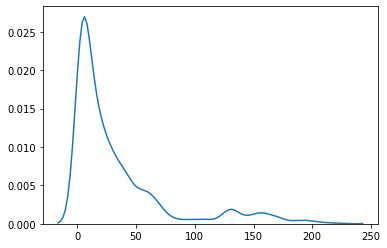

In [415]:
kdeplot(all_test_ranks)

In [395]:
test.shape

(157161, 243)

In [340]:
np.median(rm_ranked[trm])

17.0

In [373]:
trm

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [250]:
rankdata(-lc_preds.toarray()[0])[lc_preds.toarray()[0]==0]

array([223., 223., 223., 223., 223., 223., 223., 223., 223., 223., 223.,
       223., 223., 223., 223., 223., 223., 223., 223., 223., 223., 223.,
       223., 223., 223., 223., 223., 223., 223., 223., 223., 223., 223.,
       223., 223., 223., 223., 223., 223., 223., 223.])

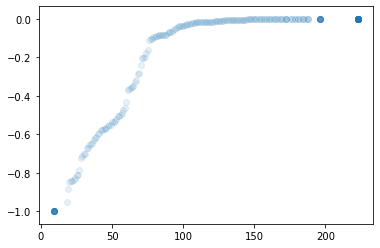

In [252]:
from scipy.stats.mstats import rankdata
plt.scatter(rankdata(-lc_preds.toarray()[0]), (-lc_preds.toarray()[0]), alpha=0.1)

In [205]:
for j,k in zip(ranks, t):
    if sum(k)!=0:
        v = np.mean(j[k])
        print(v)

66.0
3.0
2.0
3.0
129.0
14.0
156.0
58.333333333333336
15.0
41.0
32.0
25.0
5.0
99.0
59.0
4.0
2.0
218.0
2.5
158.0
2.0
64.0
3.0
60.0
117.0
1.3333333333333333
1.0
2.0
1.0
2.0
1.0
0.0
1.5
1.0
1.5
1.0
1.0
232.0
1.0
1.0
49.0
64.0
36.0
24.0
46.0
21.5
30.0
46.5
27.0
31.0
1.0
60.0
10.0
10.0
15.0
33.0
18.0
15.0
3.0
7.0
205.0
173.0
14.125
153.0
12.666666666666666
1.0
3.0
3.0
2.0
2.0
2.0
85.0
173.33333333333334
58.0
63.25
156.25
2.0
18.0
24.0
19.0
14.5
29.0
139.0
1.0
2.0
12.5
2.5
44.5
35.25
1.0
1.0
101.0
38.0
35.0
27.0
9.0
33.0
22.0
215.5
98.0
239.0
87.0
188.0
0.0
50.0
1.0
1.5
0.0
5.0
24.666666666666668
1.0
3.0
48.0
16.0
11.0
156.0
80.0
92.0
48.5
73.0
198.0
3.0
44.0
5.0
9.0
92.0
149.0
52.5
1.5
33.0
116.0
5.5
158.0
35.06060606060606
21.0
17.0
8.0
21.333333333333332
1.0
234.0
7.0
1.0
33.0
1.0
0.0
18.0
147.0
17.0
11.0
2.0
2.5
6.0
3.0
9.0
10.0
13.0
58.0
148.0
33.06666666666667
18.0
19.5
21.5
1.0
129.0
21.52
21.5
83.0
2.0
3.0
52.5
69.0
74.0
89.33333333333333
104.16666666666667
5.0
33.333333333333336
3.0


KeyboardInterrupt: 

In [204]:
k

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [200]:
preds[0][t[0]]

array([55.90005 , 29.53061 , 34.497025, 26.1203  , -8.975437],
      dtype=float32)

In [209]:
r = score_prediction_matrix(preds, test)
pr = score_prediction_matrix(lc_preds.toarray(), test)

In [341]:
pr = rm_ranked[trm]

In [342]:
pr

array([ 26., 110.,  42., ...,   5.,   3.,   5.])

38.54971932638332
17.0
33.257016840417
16.0
34.07257417802727
17.0


(0, 20)

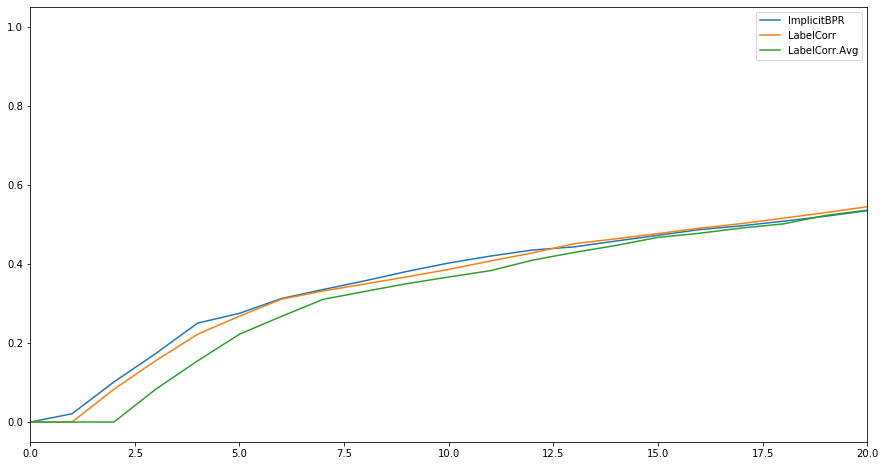

In [352]:
plt.figure(figsize=(15,8))
mean = np.mean(r)
print(mean)
median = np.median(r)
print(median)
ecdf = [(r<i).sum()/len(r) for i in range(0, 243)]
plt.plot(ecdf, label='ImplicitBPR')



pr = score_prediction_matrix(lc_preds.toarray(), test)
mean = np.mean(pr)
print(mean)
median = np.median(pr)
print(median)
ecdf = [(pr<i).sum()/len(pr) for i in range(0, 243)]
plt.plot(ecdf, label='LabelCorr')


pr = rm_ranked[trm]
mean = np.mean(pr)
print(mean)
median = np.median(pr)
print(median)
ecdf = [(pr<i).sum()/len(pr) for i in range(0, 243)]
plt.plot(ecdf, label='LabelCorr.Avg')

plt.legend()
##plt.ylim(0,20)
plt.xlim(0,20)

In [181]:
mean = np.mean(lc_ranks)
print(mean)
median = np.median(lc_ranks)
print(median)
ecdf = [(lc_ranks<i).sum()/len(lc_ranks) for i in range(0, 243)]


20.69836956521739
5.0


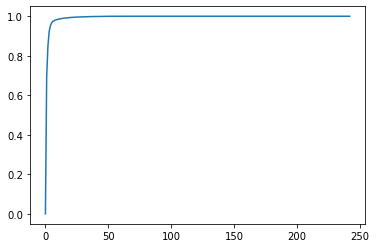

In [108]:
plt.plot(ecdf)

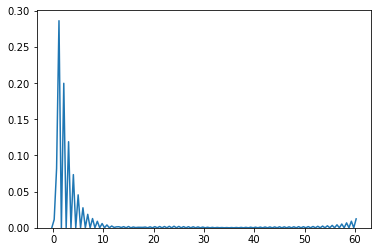

In [105]:
#kdeplot(lc_ranks)
kdeplot(r)


In [ ]:
#outfile = open('results.dat', 'w')
#outfile.write('algorithm, mean, median\n')

##implicit:
#als:
pars = find_opt_pars(filenames[0])
for _ in range(3):
    mean, median = train_implicit_als(pars)
    #outfile.write(filenames[0]+': '+str(mean)+' '+str(median)+'\n')

#bpr:
pars = find_opt_pars(filenames[1])
for _ in range(3):
    mean, median = train_implicit_bpr(pars)
    outfile.write(filenames[1]+': '+str(mean)+' '+str(median)+'\n')

##lightfm
#warp
pars = find_opt_pars(filenames[2])
for _ in range(3):
    mean, median = train_lightfm_warp(pars)
    outfile.write(filenames[2]+': '+str(mean)+' '+str(median)+'\n')

#bpr
pars = find_opt_pars(filenames[3])
for _ in range(3):
    mean, median = train_lightfm_bpr(pars)
    outfile.write(filenames[3]+': '+str(mean)+' '+str(median)+'\n')

#label correlation:
L1 = 1- utils.makeCorrelations(train)
prediction_matrix = utils.makeProbabilities(train, L1)
test_ranks = utils.evaluate_predictions(prediction_matrix, sparse.csr_matrix(test), avg=False)
outfile.write('label correl: '+str(np.mean(test_ranks))+' '+str(np.median(test_ranks))+'\n')


outfile.close()